In [2]:
from carbon import P, CarbonOrderUI, CarbonSimulatorUI, analytics as cal, __version__, __date__
from carbon.helpers.fls import fload, fsave
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import namedtuple
print(f"Carbon Version v{__version__} ({__date__})", )
print (f"Analytics Version v{cal.__version__} ({cal.__date__})")

Carbon Version v2.3-BETA1 (21/Jan/2022)
Analytics Version v2.1-beta2 (7/Jan/2022)


# Carbon Simulation - Demo 3-3 (Big Orderbook)

In this demo we look at an **order book**. It is very similar to 3-2 except that we now import the orderbook from a file, and that it is substantially bigger. We also trimmed down the analysis

In [3]:
DATAPATH = "data"

DATAFN = "template.json"
DATAFN = "orders.json"

In [4]:
!ls {DATAPATH}

EthUsdcOrders.json orders.json        template.json


In [5]:
data = fload(DATAFN, DATAPATH, json=True)
prices = data.get("prices", [])
print(f'Data: {len(data["orders"])} orders, {len(prices)} prices')
#data

[fload] Reading orders.json from data
Data: 256 orders, 0 prices


In [6]:
data["orders"][0]

{'amt': '254814732', 'pb': '256', 'pa': '257', 'pm': '257'}

In [7]:
meta = data["meta"]
assert meta["request"] == 'cumulative_liquidity'
assert meta["request_unit"] == 'y'
assert meta["price_unit"] == 'y/x'
assert meta["amt_unit"] == 'y'
meta

{'x': 'ETH',
 'y': 'USDC',
 'request': 'cumulative_liquidity',
 'request_unit': 'y',
 'price_unit': 'y/x',
 'amt_unit': 'y'}

In [8]:
order_nt = namedtuple("order_nt", "pa, pb, pm, amt")
orders = [order_nt(**{k:int(v) for k,v in r.items()}) for r in data["orders"]]
orders[0]

order_nt(pa=257, pb=256, pm=257, amt=254814732)

In [9]:
minp = min(min(r.pa, r.pb) for r in orders)
maxp = max(max(r.pa, r.pb) for r in orders)
minp, maxp

(1, 257)

In [10]:
if not prices:
    prices = np.linspace(minp,maxp, 100)
    prices[:4]
else:
    prices = [float(p) for p in prices]

In [11]:
inverted = [(r.pa, r.pb) for r in orders if r.pa <= r.pb]
if inverted:
    raise RuntimeError("Must have pa >= pb", inverted)

In [12]:
notfull = [(r.pa, r.pm) for r in orders if r.pa != r.pm]
if notfull:
    raise RuntimeError("Must have not have pa != pm", notfull)

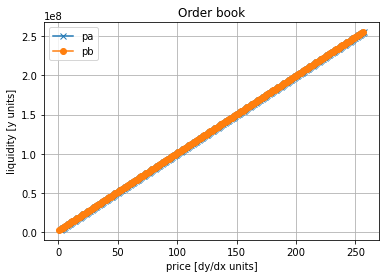

In [13]:
plt.plot([r.pa for r in orders], [r.amt for r in orders], marker="x", label="pa")
plt.plot([r.pb for r in orders], [r.amt for r in orders], marker="o", label="pb")
plt.title("Order book")
plt.xlabel("price [dy/dx units]")
plt.ylabel("liquidity [y units]")
plt.legend()
plt.grid()

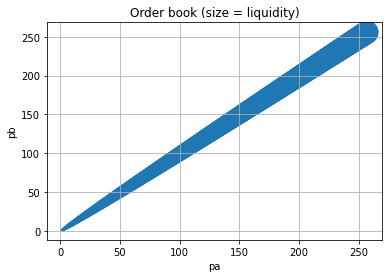

In [14]:
sizes = np.array([r.amt for r in orders])
maxsize = max(sizes)
plt.scatter([r.pa for r in orders], [r.pb for r in orders], s=sizes/maxsize*500)
plt.title("Order book (size = liquidity)")
plt.xlabel("pa")
plt.ylabel("pb")
plt.grid()

In [15]:
#[r.amt for r in orders]

## Setup

In [16]:
PAIR = P(tknq=meta["y"], tknb=meta["x"])
Sim = CarbonSimulatorUI(pair=PAIR, verbose=False, raiseonerror=True)
CA = cal.Analytics(Sim, verbose=True)
for o in orders:
    Sim.add_order(meta["y"], o.amt, o.pa, o.pb)

In [17]:
Sim.state()["orders"].query("disabled==False")

,id,pair,tkn,y_int,y,y_unit,disabled,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,USDC,254814732.0,254814732.0,USDC,False,257.0,256.0,257.0,USDC per ETH,1
2,2,ETHUSDC,USDC,253827078.0,253827078.0,USDC,False,256.0,255.0,256.0,USDC per ETH,3
4,4,ETHUSDC,USDC,252839424.0,252839424.0,USDC,False,255.0,254.0,255.0,USDC per ETH,5
6,6,ETHUSDC,USDC,251851770.0,251851770.0,USDC,False,254.0,253.0,254.0,USDC per ETH,7
8,8,ETHUSDC,USDC,6913578.0,6913578.0,USDC,False,6.0,5.0,6.0,USDC per ETH,9
...,...,...,...,...,...,...,...,...,...,...,...,...
502,502,ETHUSDC,USDC,250864116.0,250864116.0,USDC,False,253.0,252.0,253.0,USDC per ETH,503
504,504,ETHUSDC,USDC,5925924.0,5925924.0,USDC,False,5.0,4.0,5.0,USDC per ETH,505
506,506,ETHUSDC,USDC,4938270.0,4938270.0,USDC,False,4.0,3.0,4.0,USDC per ETH,507
508,508,ETHUSDC,USDC,3950616.0,3950616.0,USDC,False,3.0,2.0,3.0,USDC per ETH,509


In [18]:
Sim.liquidity(Sim.ASDF)

y
pair    tkn               
ETHUSDC ETH   0.000000e+00
        USDC  3.299554e+10

In [19]:
curves_by_pair_bidask = CarbonOrderUI.curves_by_pair_bidask(Sim.state()["orderuis"])
print(list(curves_by_pair_bidask.keys()))

['ETH/USDC']


## Approximate liquidity

In [20]:
liq =  cal.calc_liquidity_approx(Sim.state()["orderuis"], prices, PAIR, reverse=True)
liqr = cal.calc_liquidity_approx(Sim.state()["orderuis"], prices, PAIR, reverse=False)

[calc_liquidity_approx] pair:ETHUSDC ETH USDC
[calc_liquidity_approx] ask:256 bid:256
[calc_liquidity_approx] tkn=USDC
[calc_liquidity_approx] pair:ETHUSDC ETH USDC
[calc_liquidity_approx] ask:256 bid:256
[calc_liquidity_approx] tkn=ETH


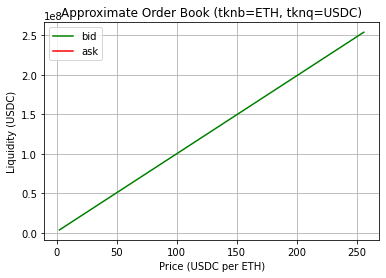

In [21]:
cal.plot_approx_orderbook_chart(liq)

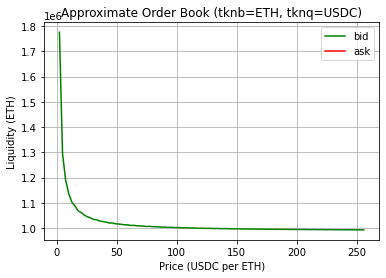

In [22]:
cal.plot_approx_orderbook_chart(liqr)

## AMM BUYS base token (BID side)

In [23]:
curves = curves_by_pair_bidask[PAIR.slashpair]["BID"]
c0 = curves[0]
print(f"pair={c0.pair.slashpair} [{c0.pair.price_convention}] tkny={c0.tkny} tknx={c0.tknx}")
dy_p = lambda p: sum(c.dyfromp_f(p) for c in curves)
dx_p = lambda p: sum(c.dxfromdy_f(c.dyfromp_f(p)) for c in curves)
dy_amounts = [dy_p(p) for p in prices]
dx_amounts = [dx_p(p) for p in prices]

pair=ETH/USDC [USDC per ETH] tkny=USDC tknx=ETH


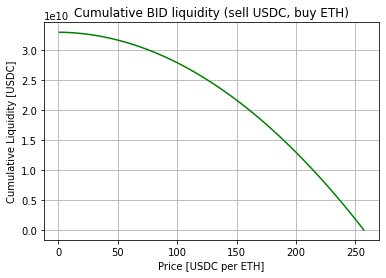

In [24]:
plt.plot(prices, dy_amounts, color="green")
plt.title(f"Cumulative BID liquidity (sell {c0.tkny}, buy {c0.tknx})")
plt.xlabel(f"Price [{c0.pair.price_convention}]")
plt.ylabel(f"Cumulative Liquidity [{c0.tkny}]")
plt.grid()

In [25]:
cumul_df = pd.DataFrame([prices, dy_amounts]).T
cumul_df.columns = [f"Price [{c0.pair.price_convention}]", f"Cumulative Liquidity [{c0.tkny}]"]
cumul_df

,Price [USDC per ETH],Cumulative Liquidity [USDC]
0,1.000000,3.299554e+10
1,3.585859,3.298565e+10
2,6.171717,3.296945e+10
3,8.757576,3.294653e+10
4,11.343434,3.291700e+10
...,...,...
95,246.656566,2.587767e+09
96,249.242424,1.950721e+09
97,251.828283,1.307070e+09
98,254.414141,6.567097e+08


In [26]:
OB2 = cal.OrderBook(dx_amounts, dy_amounts, PAIR.tknb, PAIR.tknq, bidask=cal.OrderBook.BID)
print(OB2.explain())

This is the BID book.
Source token = ETH, target token = USDC.
AMM buys ETH for USDC.
Base token = ETH, quote token = USDC.
Prices are quoted in USDC per ETH.
Order book amounts are quoted in USDC.


'plotted tokens received against trade size (32,995,544,832)'

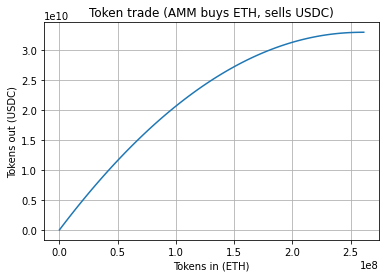

In [27]:
OB2.plot_tokenamount_chart()

In [28]:
OB2.data_tokenamount_chart(aspandas=True)

,src_amt [ETH],trg_amt [USDC]
0,2.612093e+08,3.299554e+10
1,2.565934e+08,3.298565e+10
2,2.532582e+08,3.296945e+10
3,2.501813e+08,3.294653e+10
4,2.472419e+08,3.291700e+10
...,...,...
95,1.027593e+07,2.587767e+09
96,7.706676e+06,1.950721e+09
97,5.137574e+06,1.307070e+09
98,2.568212e+06,6.567097e+08


'plotted marginal and effective prices against trade size'

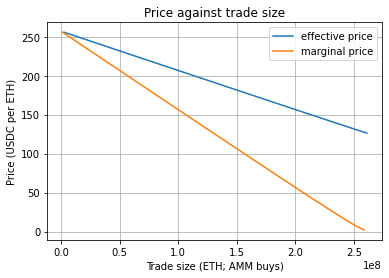

In [29]:
OB2.plot_price_chart()

In [30]:
OB2.data_price_chart(aspandas=True)

,size1 [ETH],price1_eff [USDC per ETH],size2 [ETH],price2_marg [USDC per ETH]
0,2.612093e+08,126.318405,2.589014e+08,2.142925
1,2.565934e+08,128.552230,2.549258e+08,4.857609
2,2.532582e+08,130.181170,2.517198e+08,7.450158
3,2.501813e+08,131.690624,2.487116e+08,10.046466
4,2.472419e+08,133.136827,2.458176e+08,12.630458
...,...,...,...,...
95,1.027593e+07,251.827923,8.991305e+06,247.949628
96,7.706676e+06,253.120872,6.422125e+06,250.535293
97,5.137574e+06,254.413821,3.852893e+06,253.121300
98,2.568212e+06,255.706919,1.284106e+06,255.706919


'plotted order book (-32,662,244,199)'

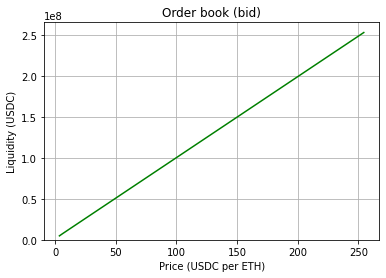

In [31]:
OB2.plot_orderbook_chart()

In [32]:
OB2.data_orderbook_chart(aspandas=True)

,Price [USDC per ETH],Liquidity [USDC]
0,3.500267,4.805813e+06
1,6.153883,7.545606e+06
2,8.748312,1.010174e+07
3,11.338462,1.267602e+07
4,13.924394,1.523001e+07
...,...,...
93,244.070640,2.425423e+08
94,246.656580,2.450873e+08
95,249.242461,2.476533e+08
96,251.828297,2.501948e+08


## Create template file

In [33]:
orders = [
    {"pa": 2500-i*100, "pb": 2000, "pm": 2500-i*100, "amt": 100*(5-i)}
    for i in range (5)
]
#orders

In [34]:
prices = [int(x) for x in np.linspace(1500, 3000, 500)]
#prices

In [35]:
meta = {
    "x": "ETH",
    "y": "USDC",
    "request": "cumulative_liquidity",
    "request_unit": "y",
    "price_unit": "y/x",
    "amt_unit": "y",
}
#meta

In [36]:
data = {
    "orders": [{k:str(v) for k,v in o.items()} for o in orders],
    "prices": [str(x) for x in prices],
    "meta": meta,
}
#data

In [37]:
#fsave(data, "template.json", DATAPATH, json=True)
